# Multilingual ASR models with Subword Tokenization in NeMo
This notebook helps you get started with NeMo multilingual ASR models; e.g. models that can trascribe audios in more than one language. You will learn how to use an existing pre-trained multilingual model for transcription, as well as how to create and train a new one.


Please note that the current NeMo implementation is limited to models with subword tokenization. 


There are two general ways to creating multilingual models.  One could simply combine datasets from different languages into one merged dataset and train a model on that dataset. For this to work, there's no need to even keep track of the language[s] in each sample. Nor would there be an easy way to determine which language was used during inference.


The second approach, which we implemented in NeMo, centers around the idea of reusing existing pre-trained monolingual tokenizers for each language, and simply combining them. The tokenizers for each language could be trained on large non-ASR text corpora (for maximum generalization), extracted from existing monolingual NeMo checkpoints, or trained on monolingual ASR ground truth as usual.


The diagram illustrates how this works at inference time:


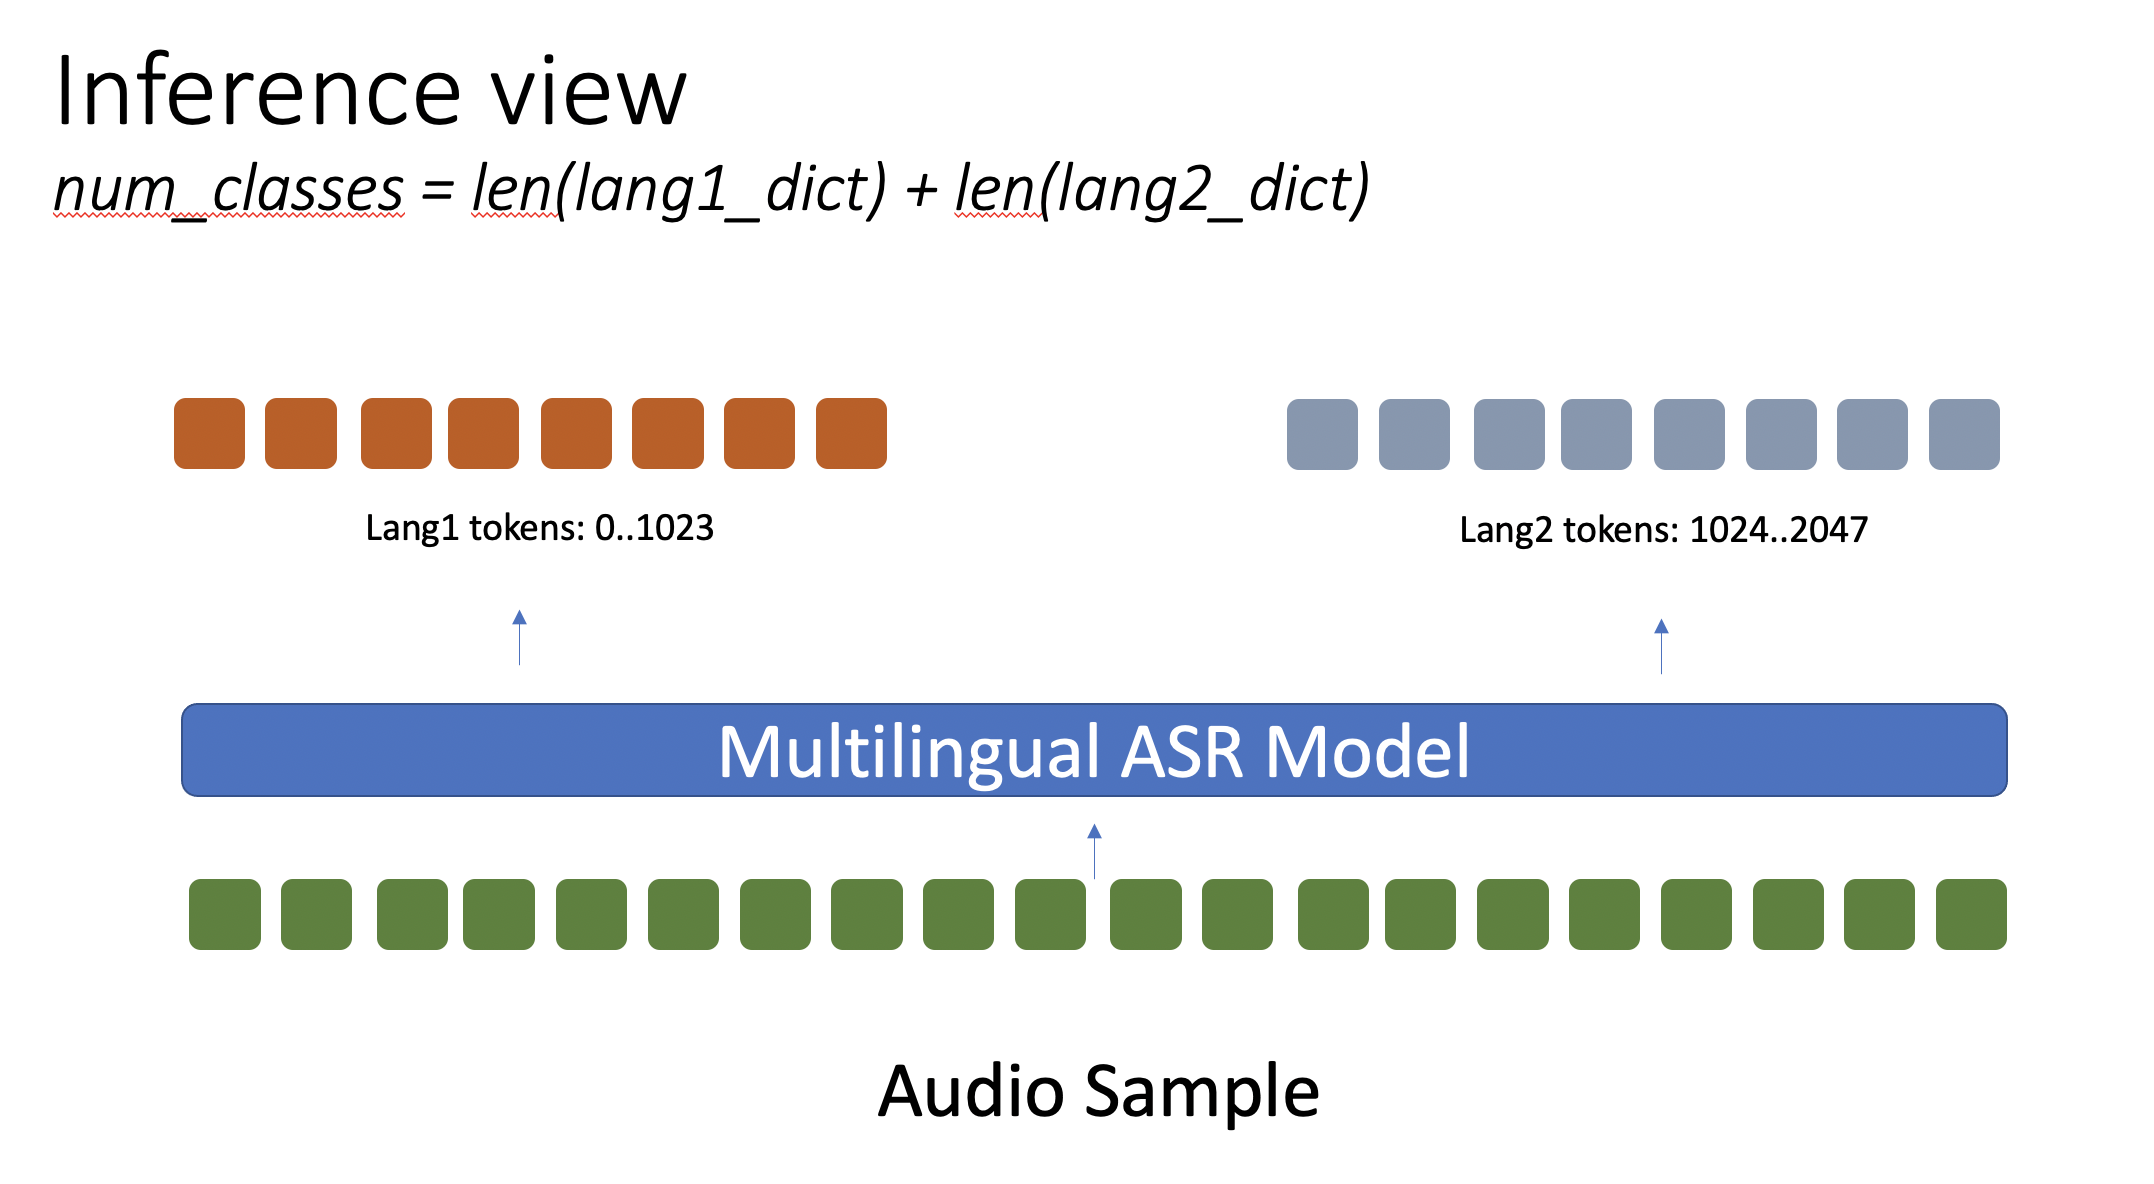

We see that each language is assigned a range of token ids and the model is trained to produce token ids in that range in order to produce samples in that language. For instance, if the token id generated by the model is 100, we know that it belongs to lang1 and should be sent to lang1 for decoding. If the token id is 1500, it belongs to lang2.  Note that we do not need to know which language a particular audio sample is in apriori; but the model generates an implicit language id for each token based on its id.

And clearly, the total number of classes the model is trained to output is simply sum of the tokenizer vocabulary lengths.

Note that we need to subtract the language offset number from each token id in order for the "as is" monolingual tokenizer to decode it.

At training time, however, we do need to provide language id for each training sample. Here's how it works:

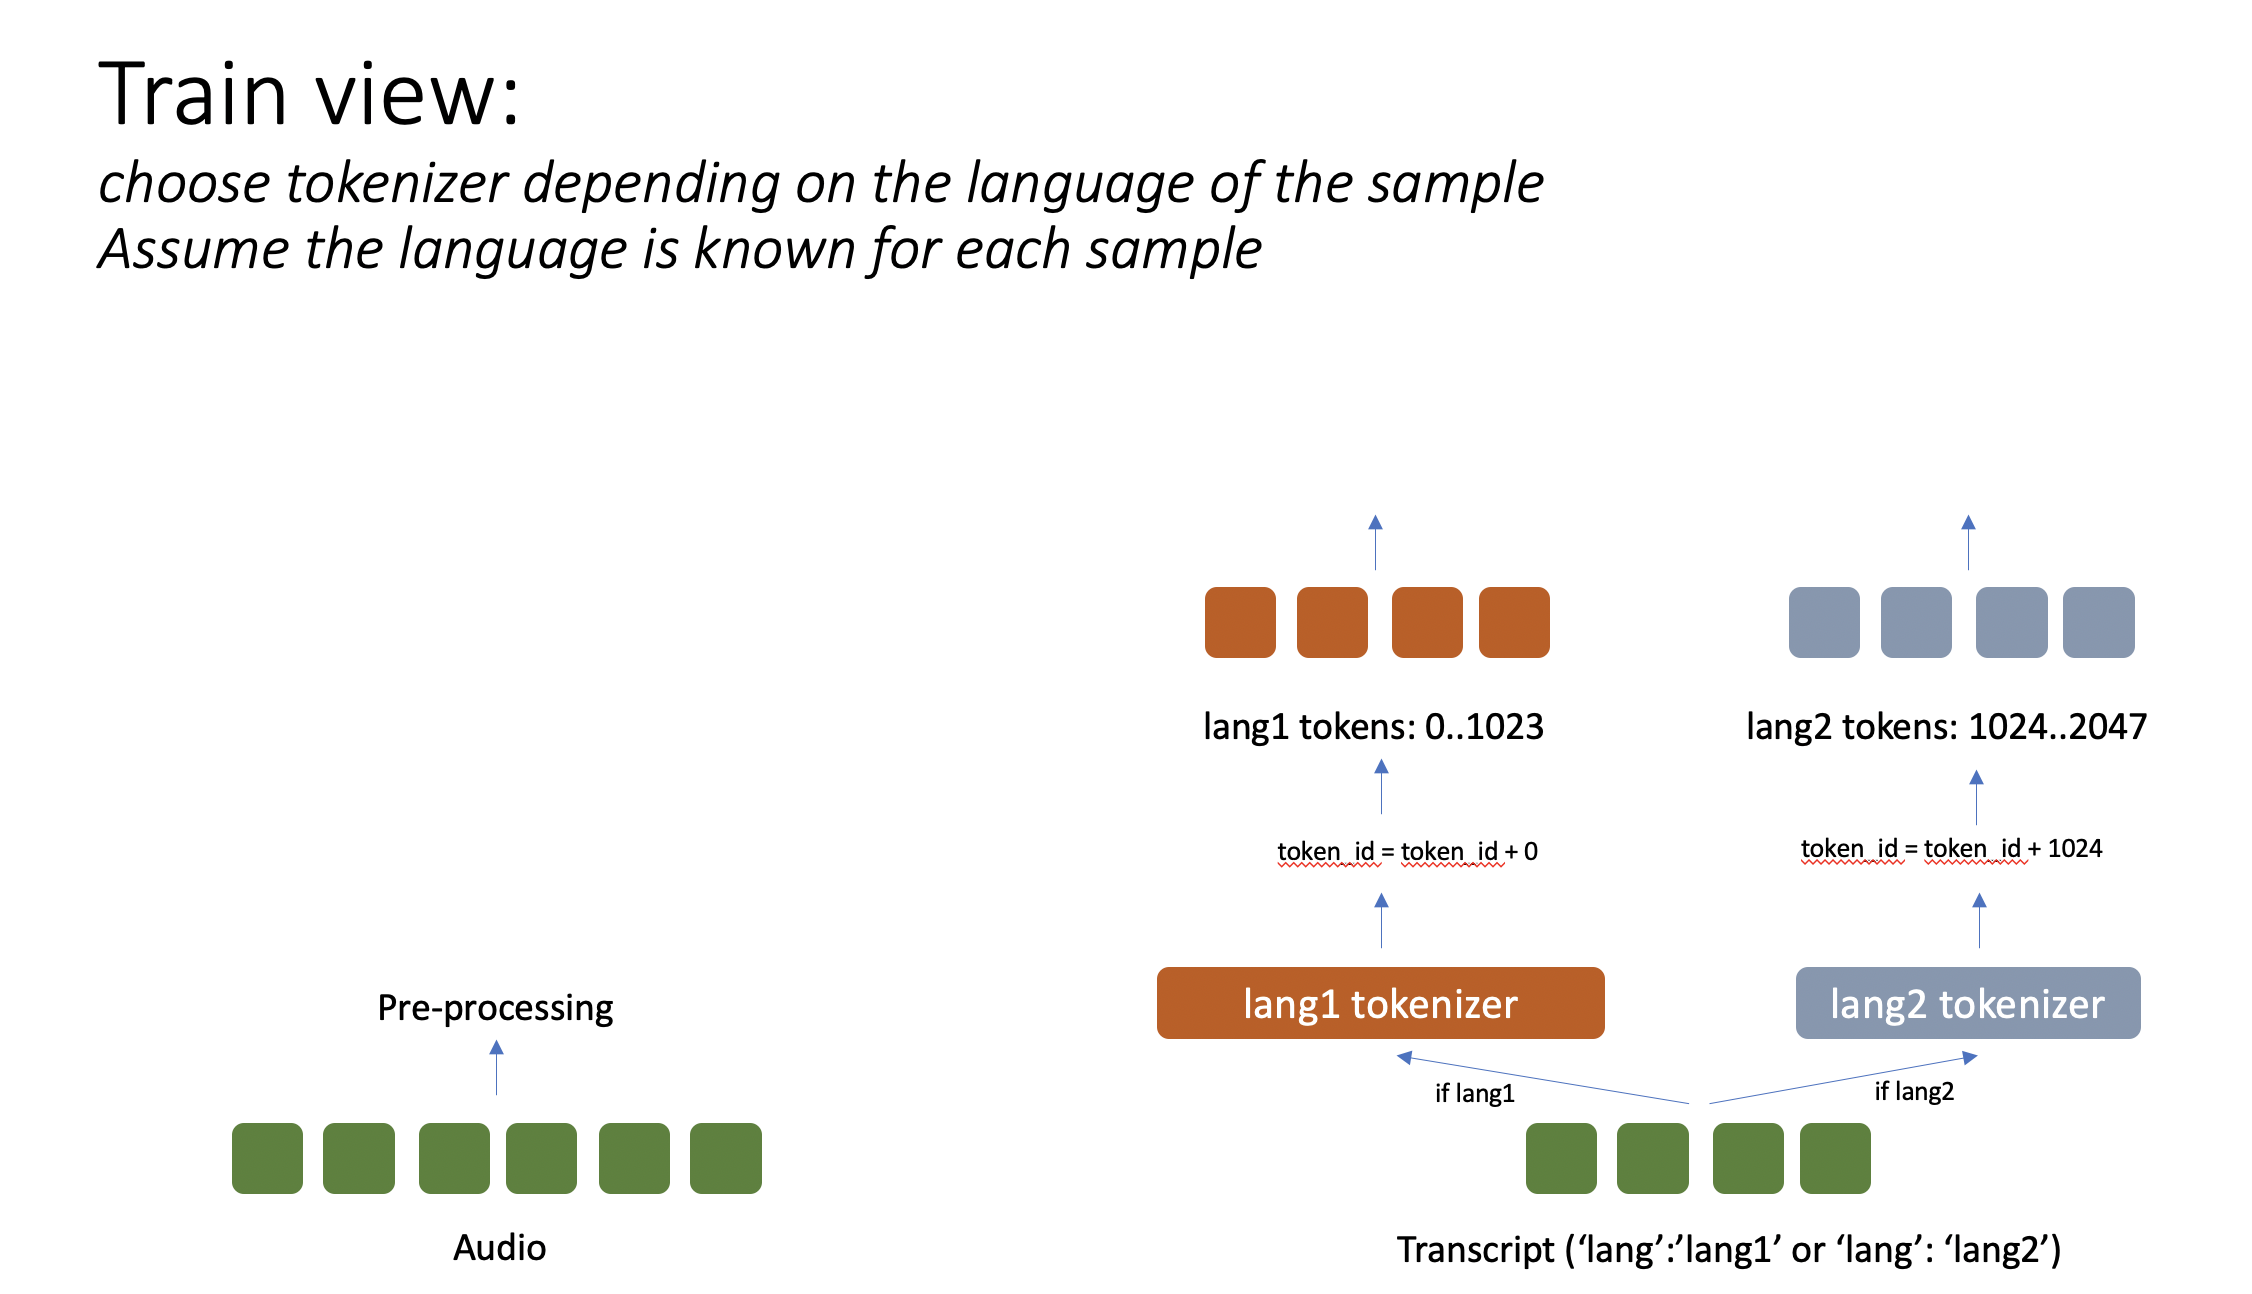

The audio for each sample is processed the same way as for the monolingual samples, but in order to generate the correct token ids for the transcripts, we need to know which tokenizer to use. Therefore, we do need an additional field ('lang') in the manifest for each sample.  After the monolingual tokenizer generates the token id, we offset it by the offset of each language and use it for model training.


Now our picture is complete. Multilingual ground truth requires an extra field, 'lang' in the manifest for each sample and a separate monolingual tokenizer for each language. 


Let's see the code now.

In [ ]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Restart the runtime (Runtime -> Restart Runtime) for any upgraded packages to take effect
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode
!pip install matplotlib>=3.3.2
# this is needed for RNNT loss
!pip install --upgrade numba

# this is needed to pre-process MCV Spanish dataset, which contains mp3 files
!apt install sox libsox-fmt-mp3

## Install NeMo
## We are using the main branch but you might want to adjust that too
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

"""
Remember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!
Alternatively, you can uncomment the exit() below to crash and restart the kernel, in the case
that you want to use the "Run All Cells" (or similar) option.
"""

In [ ]:
import nemo.collections.asr as nemo_asr
import os
from omegaconf import OmegaConf

## Datasets download
Let's download the mini Librispeech (English) dataset. It is OK for the purposes of this tutorial, but for anyhing real, you will need to get at least the entire Librispeech dataset (960 hrs).

In [ ]:
!mkdir -p datasets/mini

We will use the `get_librispeech_data.py` script located in the nemo/scripts/dataset_processing dir if you cloned NeMo repo

In [ ]:
if not os.path.exists("get_librispeech_data.py"):
    !wget https://raw.githubusercontent.com/NVIDIA/NeMo/main/scripts/dataset_processing/get_librispeech_data.py

In [ ]:
# download and pre-process the dataset
!python get_librispeech_data.py \
  --data_root "datasets/mini/" \
  --data_sets mini

Now, let's download the Mozilla CommonVoice Spanish dataset. We will ignore the larger train file and get just the test and dev parts for the purposes of this tutorial. For good results, you will need to get the train files and likely other datasets too, bringing the total to over 1k hours. 

In [ ]:
!mkdir -p datasets/mcv

We will use the `get_commonvoice_data.py` script located in the nemo/scripts/dataset_processing dir if you cloned NeMo repo

In [ ]:
if not os.path.exists("get_commonvoice_data.py"):
    !wget https://raw.githubusercontent.com/NVIDIA/NeMo/main/scripts/dataset_processing/get_commonvoice_data.py

In [ ]:
!python get_commonvoice_data.py --data_root "datasets/mcv" --language es --files_to_process test.tsv dev.tsv

To save time, let us create smaller subsets of the Spanish dataset for training and validation

In [ ]:
!head -1000 commonvoice_dev_manifest.json > commonvoice_dev_manifest_1000.json
!head -1500 commonvoice_test_manifest.json > commonvoice_test_manifest_1500.json

We will return to these datasets later for additional processing.

# Inference
Pretrained Multilingual models can be worked with in the same way as monolingual ones. Let us start by downloading a pre-trained checkpoint from NGC.

In [ ]:
m = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(model_name="stt_enes_contextnet_large")

Let's take a look at the tokenizer of this model:

In [ ]:
m.cfg.tokenizer

In [ ]:
m.tokenizer.langs

In [ ]:
!head -3 commonvoice_dev_manifest.json

We see that there are two tokenizers: English and Spanish, packaged inside the nemo tar archive. They are aggregated together using a special AggregateTokenizer class. 

In this case, there are two tokenizers, but you can have as many as you want.

Let's transcribe some audio!

In [ ]:
en_files = ["/content/datasets/mini/LibriSpeech/dev-clean-2-processed/7976-110523-0000.wav", "/content/datasets/mini/LibriSpeech/dev-clean-2-processed/7976-110523-0001.wav"]

In [ ]:
import librosa
import IPython.display as ipd

# Load and listen to an english audio sample
audio, sample_rate = librosa.load(en_files[1])

ipd.Audio(audio, rate=sample_rate)

In [ ]:
transcripts = m.transcribe(paths2audio_files = en_files) [0]

In [ ]:
transcripts

In [ ]:
es_files = ['/content/datasets/mcv/dev/wav/common_voice_es_20067220.wav', '/content/datasets/mcv/dev/wav/common_voice_es_20067221.wav']

In [ ]:
# Now let's listen to a Spanish sample:
audio, sample_rate = librosa.load(es_files[0])

ipd.Audio(audio, rate=sample_rate)

In [ ]:
m.transcribe(paths2audio_files = es_files) [0]

We see that audio samples from both languages are transcribed well.

# Tokenizers

Training - or finetuning - a multilingual ASR model is no different to how you would do that with a monolingual model. The only difference is that you would need to specify the language [id] for each sample in the manifest, e.g.
```
# {"audio_filepath": "/data/datasets/LibriSpeech/dev-clean-processed/422-122949-0002.wav", "duration": 4.475, "text": "we truthful ones the nobility in ancient greece called themselves", "lang": "en"}
```
These language ids obviously need to correspond to the language ids in your model's tokenizer config that we saw above, e.g.

```
tokenizer:
  type:agg
  langs:
    en:
      type: bpe
      dir: en_tokenizer_dir
    es:
      type: bpe
      dir: es_tokenizer_dor
```
As long as these are in place, training or fine tuning can proceed as usual.

But, what if we are trying to create a brand new multilingual model and we want to start from a checkpoint created from a different language set?

Let's start with a small Conformer Transduder checkpoint pre-trained on English:

In [ ]:
m = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(model_name="stt_en_conformer_transducer_small")

We will need to change the tokenizer for our loaded checkpoint to a multilingual one. You also could simply transfer an already trained tokenizer from another nemo model - every .nemo archive has the tokenizer (or more than one tokenizer) packaged inside.

You also could train the tokenizer on any NLP ground truth - not necessarily ASR ground truth, potentially leading to better results.  

But the *simplest* way of doing this would be to train a tokenizer on our datasets at hand.  Let's see how we can do that:  


Let's download the tokenizer creation script:

In [ ]:
if not os.path.exists("process_asr_text_tokenizer.py"):
  !wget  https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tokenizers/process_asr_text_tokenizer.py

Now let's create / train our tokenizers on our training manifests. You will noticed later that we will train the model on the "test" manifests and validate it against the "dev" manifests - just to shorten training time. We will also train our Spanish tokenizer on the entire test manifest, not limiting it to the first 1500 lines.

In [ ]:
ENGLISH_TOKENIZER_DIR = "tokenizers/en"
SPANISH_TOKENIZER_DIR = "tokenizers/es"
!mkdir -p ${ENGLISH_TOKENIZER_DIR}
!mkdir -p ${SPANISH_TOKENIZER_DIR}

We will use the entire Spanish test manifest to train our tokenizer to improve results. The more data is usually the better.

In [ ]:
!python process_asr_text_tokenizer.py \
  --manifest="commonvoice_test_manifest.json" \
  --data_root=$SPANISH_TOKENIZER_DIR \
  --vocab_size=128 \
  --tokenizer="spe" \
  --spe_type=bpe \
  --spe_character_coverage=1.0 \
  --log

In [ ]:
!python process_asr_text_tokenizer.py \
  --manifest="datasets/mini/train_clean_5.json" \
  --data_root=$ENGLISH_TOKENIZER_DIR \
  --vocab_size=128 \
  --tokenizer="spe" \
  --spe_type=bpe \
  --spe_character_coverage=1.0 \
  --log

In [ ]:
!ls $ENGLISH_TOKENIZER_DIR/tokenizer_spe_bpe_v128
!ls $SPANISH_TOKENIZER_DIR/tokenizer_spe_bpe_v128

All good. Let's get a Spanish tokenizer from a Spanish model

Now we can create a config for our new aggregate Tokenizer.

In [ ]:
from omegaconf import OmegaConf
new_tokenizer_cfg = OmegaConf.create({'type': 'agg', 'langs': {}})
english_tokenizer_cfg = OmegaConf.create({'dir': ENGLISH_TOKENIZER_DIR + '/tokenizer_spe_bpe_v128', 'type': 'bpe'})
spanish_tokenizer_cfg = OmegaConf.create({'dir': SPANISH_TOKENIZER_DIR + '/tokenizer_spe_bpe_v128', 'type': 'bpe'})
new_tokenizer_cfg.langs['en'] = english_tokenizer_cfg
new_tokenizer_cfg.langs['es'] = spanish_tokenizer_cfg

And apply it to our loaded checkpoint.  Note that this completely replaces the decoder.

In [ ]:
m.change_vocabulary(
        new_tokenizer_dir=new_tokenizer_cfg,
        new_tokenizer_type="agg",
    )

The tokenizer has been changed, let's save our new checkpoint!

In [ ]:
m.save_to("enes.nemo")

Now, let's load this new checkpoint and make sure the tokenizer config looks ok:

In [ ]:
m = nemo_asr.models.EncDecRNNTBPEModel.restore_from(restore_path="enes.nemo")

In [ ]:
print(m.cfg.tokenizer)
print(m.tokenizer.langs)

This new checkpoint has encoder weights from the English model, but the decoder has been reinitialized. Let's see how well it does on English speech:

In [ ]:
m.transcribe(paths2audio_files = en_files)[0]

How about Spanish?

In [ ]:
m.transcribe(paths2audio_files = es_files)[0]

Yeah, didn't think so. The model needs to be fine tuned before we can use it.

## The training / validation sets
We previously downloaded an English and Spanish dataset, but we will need to make adjustments in order to use them for training and eval

Let us take a look at the preprocessed mini librispeech manifest:

In [ ]:
train_manifest_en_in = "datasets/mini/train_clean_5.json"
val_manifest_en_in = "datasets/mini/dev_clean_2.json"

In [ ]:
!head -5 $train_manifest_en_in

As described above, multilingual models require the language id field for each sample. This manifest is all english, so it's easy to add the lang: 

In [ ]:
train_manifest_en = "datasets/mini/train_clean_5_en.json"
val_manifest_en = "datasets/mini/dev_clean_2_en.json"

In [ ]:
import json
def add_lang(in_manifest_file, out_manifest_file, lang):
    with open(in_manifest_file) as in_file:
        with open(out_manifest_file, 'w') as out_file:
            for line in in_file:
                o = json.loads(line)
                o['lang'] = lang
                s = json.dumps(o)
                out_file.write(s + '\n')

In [ ]:
add_lang(train_manifest_en_in, train_manifest_en, 'en')
add_lang(val_manifest_en_in, val_manifest_en, 'en')

Same needs to done to Spanish manifests. Note that we will use the entire Spanish test manifest for training in order to improve results - even though this creates an imbalanced training set. You can try to use the smaller (1500) manifest too for quicker training, but the outcome will be tricky. We can still keep the Spanish validation set small.

In [ ]:
# train_manifest_es_in = "commonvoice_test_manifest_1500.json"
train_manifest_es_in = "commonvoice_test_manifest.json"
val_manifest_es_in = "commonvoice_dev_manifest_1000.json"
# train_manifest_es = "commonvoice_test_manifest_1500_es.json"
train_manifest_es = "commonvoice_test_manifest_es.json"
val_manifest_es = "commonvoice_dev_manifest_1000_es.json"

In [ ]:
add_lang(train_manifest_es_in, train_manifest_es, 'es')
add_lang(val_manifest_es_in, val_manifest_es, 'es')

Let's check that the lang fields were added:

In [ ]:
!head -3 $train_manifest_en

In [ ]:
!head -3 $train_manifest_es

Great! Let us initialize the PyTorch Lightning trainer. Note that we are using native 16-bit precision. Please change this to 32 bit if your model shows any signs of divergence.

In [ ]:
import torch
import pytorch_lightning as ptl

# The trainer
We will run for 30 epochs, even though you will likely see good results at about 10-15. You may want to increase gradient accumulation if the loss oscillates too much.  If your machine has more than one GPU, add them to the GPUs list. 

In [ ]:
GRAD_ACCUM=1
MAX_EPOCHS=30
GPUS=[0]
LOG_EVERY_N_STEPS=10

trainer = ptl.Trainer(gpus=GPUS, 
                      accelerator="gpu",
                      max_epochs=MAX_EPOCHS, 
                      accumulate_grad_batches=GRAD_ACCUM,
                      precision=16,
                      checkpoint_callback=False,
                      logger=False,
                      log_every_n_steps=LOG_EVERY_N_STEPS,
                      progress_bar_refresh_rate=1,
                      check_val_every_n_epoch=1)

In [ ]:
m.set_trainer(trainer)

Now the training dataloader. Observe that we will be training on a mix of spanish and english

In [ ]:
train_ds = {}
train_ds['manifest_filepath'] = [train_manifest_en,train_manifest_es]
train_ds['sample_rate'] = 16000
train_ds['batch_size'] = 16
train_ds['fused_batch_size'] = 16
train_ds['shuffle'] = True
train_ds['max_duration'] = 16.7
# test_ds['use_start_end_token'] = False
train_ds['pin_memory'] = True
train_ds['is_tarred'] = False
train_ds['num_workers'] = 4

In [ ]:
m.setup_training_data(train_data_config=train_ds)  

The validation dataset, same thing. The batch size for validation could be higher since memory pressure is lower

In [ ]:
validation_ds = {}
validation_ds['sample_rate'] = 16000
validation_ds['manifest_filepath'] = [val_manifest_en,val_manifest_es]
validation_ds['batch_size'] = 32
validation_ds['shuffle'] = False
validation_ds['num_workers'] = 4

We will use the 'setup_multiple_validation_data' call to see validation numbers for English and Spanish datasets separately

In [ ]:
# m.setup_validation_data(val_data_config=validation_ds) 
m.setup_multiple_validation_data(val_data_config=validation_ds) 

Now, let us tweak the model optimizer parameters. The model was pre-trained with a higher learning rate; we may want to lower it a little for fine tuning.

In [ ]:
from omegaconf import open_dict
with open_dict(m.cfg.optim):
    m.cfg.optim.lr = 2
    m.cfg.optim.weight_decay = 0
    m.cfg.optim.sched.warmup_steps = None  # Remove default number of steps of warmup
    m.cfg.optim.sched.warmup_ratio = 0.10  # 10 % warmup
    m.cfg.optim.sched.min_lr = 1e-9

Let us freeze the encoder for easier initial convergence and faster training. On a smaller dataset when retraining the decoder, this is often a good idea.


In [ ]:
import torch
import torch.nn as nn

def enable_bn_se(m):
    if type(m) == nn.BatchNorm1d:
        m.train()
        for param in m.parameters():
            param.requires_grad_(True)


In [ ]:
m.encoder.freeze()
m.encoder.apply(enable_bn_se)

Finally, let's set up an experiment manager to keep track of our checkpoints.  Also, we want to use W&B for experiment management!

In [ ]:
import wandb

Since we will use Weights and Biases to observe our run, you will need an account.  You will also need to rename the project name and experiment name.

In [ ]:
WANDB_PROJ_NAME = "multilang_asr"
WANDB_EXP_NAME = "tutorial"

In [ ]:
# enter your W&B key when prompted
wandb.login(relogin=True)

The Nemo experiment manager will interface with W&B as well as save your intermediate checkpoints.

In [ ]:
from nemo.utils import exp_manager
import os

# Environment variable generally used for multi-node multi-gpu training.
# In notebook environments, this flag is unnecessary and can cause logs of multiple training runs to overwrite each other.
os.environ.pop('NEMO_EXPM_VERSION', None)

# change the exp_dir
config = exp_manager.ExpManagerConfig(
    exp_dir=f'experiments/multi/',
    name=f"ASR-Model-multi",
    checkpoint_callback_params=exp_manager.CallbackParams(
        monitor="val_wer",
        mode="min",
        always_save_nemo=True,
        save_best_model=True,
    ),
    create_wandb_logger=True,
    wandb_logger_kwargs = {"name": WANDB_EXP_NAME, "project": WANDB_PROJ_NAME}
)

config = OmegaConf.structured(config)

logdir = exp_manager.exp_manager(trainer, config)

# Train
Now we start our run with a frozen encoder.

In [ ]:
trainer.fit(m)

Let us now test our trained model on the English validation set to measure the WER:

In [ ]:
test_ds_en = {}
test_ds_en['sample_rate'] = 16000
test_ds_en['manifest_filepath'] = [val_manifest_en]
test_ds_en['batch_size'] = 32
test_ds_en['num_workers'] = 4

In [ ]:
m.setup_test_data(test_data_config=test_ds_en)

In [ ]:
trainer.test(m)

We should get a WER of about 16%.

How about Spanish?

In [ ]:
test_ds_es = {}
test_ds_es['sample_rate'] = 16000
test_ds_es['manifest_filepath'] = [val_manifest_es]
test_ds_es['batch_size'] = 32
test_ds_es['num_workers'] = 4

In [ ]:
m.setup_test_data(test_data_config=test_ds_es)

In [ ]:
trainer.test(m)

Spanish WER is considerably worse; around 48%, despite the fact that we are using a frozen encoder that only saw English speech!

In [ ]:
m.save_to("multi_trained.nemo")

# Next steps
For better results, try continuing to fine tune from the above checkpoint with an unfrozen encoder.  Also, try to download the Librispeech english
and Mozilla Commonvoice Spanish datasets and finetune on them directly - you will not need to freeze the encoder as the first step.